In [2]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
import sys
from ahrs.filters import EKF
from ahrs.common.orientation import acc2q
import math


DATA GENERATION

In [3]:
# Assuming a sampling rate of 1 sample per second
SAMPLING_RATE = 1
TOTAL_TIME = 3600
STARTING_POSE = R.from_matrix(np.eye(3))    # Identity means no rotation, i.e. pointing north
ROTATIONAL_VELOCITY = np.array([0, 0, 2.0 * np.pi / 3600])    # this is the rotational velocity in rad/s of 3 rotation (2 pi) in the Z axis per hour (3600 seconds)
#2.0 * np.pi / 3600
NORTH_VECTOR = np.array([ 25, 0, 0])     # 25 uT north
DOWN_VECTOR = np.array([0, 0, -9.8])       # 9.8 m/s/s down

In [4]:
# use the initial pose and rote velocity to calculate an initial Q and the resulting Q from the rotation and then compare this to the quater 
# generated from converting euler to Q below

In [5]:
# XYX, XYZ, XZX, XZY, YXY, YXZ, YZX, YZY, YZY, ZXZ*, ZYX, ZYZ

In [6]:
rotational_velocity_update_matrix = R.from_euler('XYZ', ROTATIONAL_VELOCITY / SAMPLING_RATE)

ideal_acc = np.zeros((TOTAL_TIME * SAMPLING_RATE, 3))
ideal_gyr = np.zeros((TOTAL_TIME * SAMPLING_RATE, 3))
ideal_mag = np.zeros((TOTAL_TIME * SAMPLING_RATE, 3))

curr_pose_arr = []
curr_pose_arr_quat = []

current_pose = STARTING_POSE
for i in range(TOTAL_TIME * SAMPLING_RATE):
    
    current_pose = current_pose * rotational_velocity_update_matrix
    
    c = current_pose.as_matrix()
    r = R.from_matrix(c)
    r_quat = r.as_quat()
    r_eul = R.from_quat(r_quat).as_euler('XYZ')
    curr_pose_arr_quat.append(r_quat)
    curr_pose_arr.append(r_eul)
    
    ideal_acc[i,:] = np.matmul(DOWN_VECTOR, current_pose.as_matrix())
    ideal_gyr[i,:] = ROTATIONAL_VELOCITY
    ideal_mag[i,:] = np.matmul(NORTH_VECTOR, current_pose.as_matrix())
    
t = np.arange(0, TOTAL_TIME, 1 / SAMPLING_RATE)

In [10]:
curr_pose_arr_quat

[array([0.00000000e+00, 0.00000000e+00, 8.72664515e-04, 9.99999619e-01]),
 array([0.        , 0.        , 0.00174533, 0.99999848]),
 array([0.        , 0.        , 0.00261799, 0.99999657]),
 array([0.        , 0.        , 0.00349065, 0.99999391]),
 array([0.        , 0.        , 0.00436331, 0.99999048]),
 array([0.        , 0.        , 0.00523596, 0.99998629]),
 array([0.        , 0.        , 0.00610861, 0.99998134]),
 array([0.        , 0.        , 0.00698126, 0.99997563]),
 array([0.        , 0.        , 0.0078539 , 0.99996916]),
 array([0.        , 0.        , 0.00872654, 0.99996192]),
 array([0.        , 0.        , 0.00959916, 0.99995393]),
 array([0.        , 0.        , 0.01047178, 0.99994517]),
 array([0.        , 0.        , 0.0113444 , 0.99993565]),
 array([0.        , 0.        , 0.012217  , 0.99992537]),
 array([0.        , 0.        , 0.0130896 , 0.99991433]),
 array([0.        , 0.        , 0.01396218, 0.99990252]),
 array([0.        , 0.        , 0.01483475, 0.99988996])

In [11]:
num_samples = 3600 
curr_pose = np.zeros((num_samples, 3))
for i in range(num_samples):
    curr_pose[i] = curr_pose_arr[i]

(0.0, 3600.0)

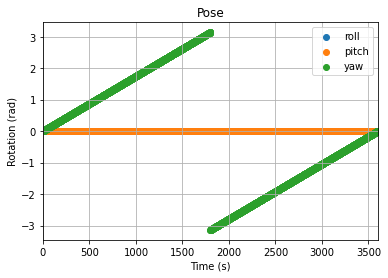

In [12]:
plt.scatter(t, curr_pose[:,0], label='roll')
plt.scatter(t, curr_pose[:,1], label='pitch')
plt.scatter(t, curr_pose[:,2], label='yaw')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Rotation (rad)')
plt.title("Pose")
plt.grid()
plt.xlim(0,3600)



In [13]:
# visualize the change in current pose

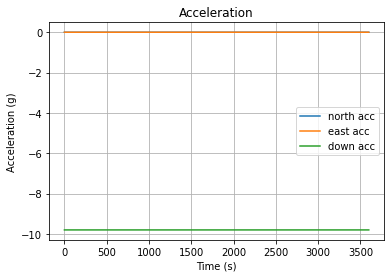

In [14]:
plt.plot(t, ideal_acc[:,0], label='north acc')
plt.plot(t, ideal_acc[:,1], label='east acc')
plt.plot(t, ideal_acc[:,2], label='down acc')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title("Acceleration")
plt.grid()

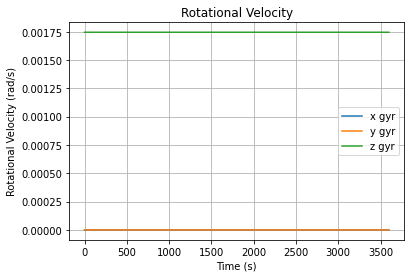

In [15]:
plt.plot(t, ideal_gyr[:,0], label='x gyr')
plt.plot(t, ideal_gyr[:,1], label='y gyr')
plt.plot(t, ideal_gyr[:,2], label='z gyr')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Rotational Velocity (rad/s)')
plt.title("Rotational Velocity")
plt.grid()

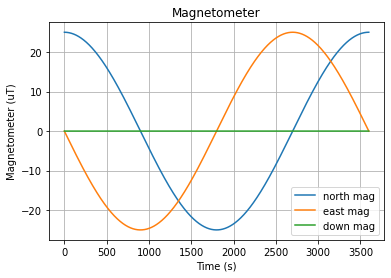

In [16]:
plt.plot(t, ideal_mag[:,0], label='north mag')
plt.plot(t, ideal_mag[:,1], label='east mag')
plt.plot(t, ideal_mag[:,2], label='down mag')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Magnetometer (uT)')
plt.title("Magnetometer")
plt.grid()

FILTER CODE AND RESULTING GRAPH

In [17]:
ekf = EKF(gyr=ideal_gyr, acc=ideal_acc, mag=ideal_mag, frequency = 1, q0 = [0,0,0,1], frame= 'NED')
num_samples = 3600                # Assuming sensors have 3600 samples each
Q = np.zeros((num_samples, 4))  # Allocate array for quaternions
# Predicted = np.zeros((num_samples, 4))
Q[0] = [0,0,0,1]

# First sample of tri-axial accelerometer
for s in range(1, num_samples):
    print(Q[s-1])
    Q[s] = ekf.update(Q[s-1], ideal_gyr[s], ideal_acc[s], ideal_mag[s]) # calculated Quaternions
#     Predicted[s] = ekf.f(Q[s-1], ideal_gyr[s])               # predicted next Quaternio

[0. 0. 0. 1.]
[ 0.01059582 -0.00337339 -0.00296704  0.99993377]
[ 0.02256901  0.00639288 -0.00578541  0.99970811]
[ 0.03609607  0.02375995 -0.0084677   0.99902995]
[ 0.05141169  0.04496866 -0.01112691  0.99760255]
[ 0.06880194  0.06741016 -0.01391233  0.99525304]
[ 0.08857531  0.08934956 -0.01697644  0.9919087 ]
[ 0.11103497  0.10970154 -0.02045673  0.98753143]
[ 0.13645955  0.12783319 -0.02446481  0.98205852]
[ 0.16509068  0.14340711 -0.02908018  0.97536343]
[ 0.19712349  0.15626832 -0.03434756  0.96723461]
[ 0.23269643  0.16636837 -0.04027638  0.95736709]
[ 0.27187794  0.17371678 -0.04684156  0.94536275]
[ 0.31464816  0.17835188 -0.05398451  0.93073778]
[ 0.36087511  0.18032509 -0.06161399  0.91293797]
[ 0.41028599  0.17969555 -0.06960657  0.89136404]
[ 0.46243594  0.1765333  -0.07780733  0.86541032]
[ 0.5166794   0.17092996 -0.0860316   0.83452017]
[ 0.57215168  0.16301585 -0.09406968  0.7982601 ]
[ 0.62777147  0.15298157 -0.10169653  0.75641089]
[ 0.68227637  0.14110022 -0.10868843

[ 0.85162515 -0.06613522 -0.12771539  0.50403326]
[ 0.85118634 -0.06624702 -0.12765771  0.50477387]
[ 0.85074683 -0.06635877 -0.12759996  0.50551418]
[ 0.85030663 -0.06647047 -0.12754214  0.5062542 ]
[ 0.84986572 -0.06658212 -0.12748425  0.50699392]
[ 0.84942412 -0.06669372 -0.12742628  0.50773335]
[ 0.84898182 -0.06680527 -0.12736824  0.50847248]
[ 0.84853882 -0.06691677 -0.12731013  0.50921131]
[ 0.84809512 -0.06702823 -0.12725194  0.50994984]
[ 0.84765072 -0.06713963 -0.12719367  0.51068806]
[ 0.84720563 -0.06725098 -0.12713534  0.51142598]
[ 0.84675984 -0.06736228 -0.12707693  0.5121636 ]
[ 0.84631335 -0.06747353 -0.12701844  0.51290092]
[ 0.84586617 -0.06758473 -0.12695988  0.51363793]
[ 0.84541829 -0.06769588 -0.12690125  0.51437463]
[ 0.84496972 -0.06780698 -0.12684254  0.51511102]
[ 0.84452045 -0.06791802 -0.12678376  0.5158471 ]
[ 0.84407048 -0.06802902 -0.1267249   0.51658288]
[ 0.84361983 -0.06813997 -0.12666597  0.51731834]
[ 0.84316848 -0.06825087 -0.12660696  0.51805349]


[ 0.58211904 -0.11144446 -0.09224291  0.80013049]
[ 0.58141361 -0.11152563 -0.09214738  0.80064293]
[ 0.58070773 -0.11160672 -0.09205179  0.80115475]
[ 0.58000141 -0.11168773 -0.09195611  0.80166594]
[ 0.57929465 -0.11176865 -0.09186036  0.80217651]
[ 0.57858746 -0.11184949 -0.09176454  0.80268644]
[ 0.57787982 -0.11193024 -0.09166865  0.80319574]
[ 0.57717174 -0.11201091 -0.09157268  0.80370441]
[ 0.57646323 -0.1120915  -0.09147663  0.80421245]
[ 0.57575428 -0.112172   -0.09138052  0.80471986]
[ 0.57504489 -0.11225242 -0.09128433  0.80522664]
[ 0.57433506 -0.11233276 -0.09118806  0.80573279]
[ 0.5736248  -0.11241301 -0.09109173  0.8062383 ]
[ 0.57291411 -0.11249318 -0.09099531  0.80674318]
[ 0.57220298 -0.11257326 -0.09089883  0.80724743]
[ 0.57149141 -0.11265326 -0.09080227  0.80775105]
[ 0.57077941 -0.11273317 -0.09070564  0.80825403]
[ 0.57006698 -0.11281301 -0.09060894  0.80875638]
[ 0.56935412 -0.11289275 -0.09051216  0.80925809]
[ 0.56864083 -0.11297241 -0.09041531  0.80975917]


[ 0.21466179 -0.1393069  -0.04094595  0.96583504]
[ 0.21381544 -0.13934319 -0.04082493  0.96602265]
[ 0.21296892 -0.13937937 -0.04070389  0.96620951]
[ 0.21212226 -0.13941545 -0.04058281  0.96639563]
[ 0.21127543 -0.13945142 -0.04046169  0.96658101]
[ 0.21042846 -0.13948729 -0.04034055  0.96676564]
[ 0.20958132 -0.13952305 -0.04021937  0.96694953]
[ 0.20873404 -0.1395587  -0.04009816  0.96713267]
[ 0.2078866  -0.13959425 -0.03997691  0.96731507]
[ 0.20703902 -0.13962969 -0.03985563  0.96749673]
[ 0.20619128 -0.13966502 -0.03973432  0.96767764]
[ 0.20534339 -0.13970025 -0.03961298  0.96785781]
[ 0.20449535 -0.13973537 -0.03949161  0.96803724]
[ 0.20364716 -0.13977039 -0.0393702   0.96821592]
[ 0.20279882 -0.13980529 -0.03924876  0.96839385]
[ 0.20195034 -0.1398401  -0.03912729  0.96857104]
[ 0.20110171 -0.13987479 -0.03900579  0.96874749]
[ 0.20025293 -0.13990938 -0.03888425  0.96892319]
[ 0.199404   -0.13994387 -0.03876268  0.96909814]
[ 0.19855493 -0.13997824 -0.03864109  0.96927235]


[-0.17898543 -0.14452231  0.01641944  0.97304055]
[-0.17983529 -0.14450834  0.01654552  0.97288378]
[-0.180685   -0.14449426  0.01667158  0.97272627]
[-0.18153458 -0.14448007  0.01679764  0.97256802]
[-0.18238401 -0.14446577  0.01692368  0.97240902]
[-0.1832333  -0.14445136  0.01704971  0.97224928]
[-0.18408245 -0.14443684  0.01717573  0.97208881]
[-0.18493145 -0.14442221  0.01730173  0.97192759]
[-0.18578031 -0.14440746  0.01742772  0.97176563]
[-0.18662902 -0.14439261  0.01755371  0.97160293]
[-0.18747758 -0.14437765  0.01767968  0.97143949]
[-0.188326   -0.14436257  0.01780563  0.97127531]
[-0.18917427 -0.14434739  0.01793158  0.97111039]
[-0.19002239 -0.14433209  0.01805751  0.97094473]
[-0.19087036 -0.14431669  0.01818343  0.97077833]
[-0.19171818 -0.14430117  0.01830933  0.97061119]
[-0.19256585 -0.14428555  0.01843523  0.97044331]
[-0.19341337 -0.14426981  0.01856111  0.97027469]
[-0.19426074 -0.14425396  0.01868698  0.97010533]
[-0.19510796 -0.14423801  0.01881283  0.96993523]


[-0.56637315 -0.12483254  0.07495562  0.81118429]
[-0.56708032 -0.12476725  0.07506471  0.81069003]
[-0.56778706 -0.12470187  0.07517375  0.81019516]
[-0.56849337 -0.12463639  0.07528273  0.80969968]
[-0.56919924 -0.12457081  0.07539165  0.80920358]
[-0.56990468 -0.12450514  0.07550052  0.80870687]
[-0.57060968 -0.12443938  0.07560933  0.80820954]
[-0.57131425 -0.12437351  0.07571808  0.8077116 ]
[-0.57201839 -0.12430756  0.07582677  0.80721304]
[-0.57272208 -0.12424151  0.07593541  0.80671388]
[-0.57342534 -0.12417536  0.07604399  0.8062141 ]
[-0.57412817 -0.12410912  0.07615251  0.8057137 ]
[-0.57483055 -0.12404278  0.07626098  0.8052127 ]
[-0.5755325  -0.12397635  0.07636938  0.80471108]
[-0.576234   -0.12390982  0.07647773  0.80420886]
[-0.57693507 -0.1238432   0.07658602  0.80370602]
[-0.5776357  -0.12377648  0.07669426  0.80320257]
[-0.57833589 -0.12370966  0.07680243  0.80269852]
[-0.57903563 -0.12364276  0.07691055  0.80219385]
[-0.57973494 -0.12357575  0.0770186   0.80168857]


[-0.85069354 -0.08273302  0.11992703  0.50506758]
[-0.8511336  -0.08262833  0.11999933  0.5043256 ]
[-0.85157302 -0.08252359  0.12007154  0.50358324]
[-0.85201179 -0.08241877  0.12014366  0.50284049]
[-0.85244992 -0.0823139   0.12021568  0.50209735]
[-0.85288739 -0.08220896  0.12028762  0.50135384]
[-0.85332422 -0.08210396  0.12035946  0.50060994]
[-0.8537604  -0.0819989   0.12043121  0.49986566]
[-0.85419593 -0.08189377  0.12050286  0.499121  ]
[-0.85463082 -0.08178858  0.12057443  0.49837596]
[-0.85506505 -0.08168333  0.1206459   0.49763055]
[-0.85549863 -0.08157802  0.12071728  0.49688475]
[-0.85593157 -0.08147264  0.12078857  0.49613857]
[-0.85636385 -0.0813672   0.12085977  0.49539201]
[-0.85679549 -0.0812617   0.12093087  0.49464508]
[-0.85722647 -0.08115614  0.12100188  0.49389777]
[-0.8576568  -0.08105051  0.1210728   0.49315008]
[-0.85808648 -0.08094483  0.12114363  0.49240202]
[-0.85851551 -0.08083908  0.12121437  0.49165358]
[-0.85894388 -0.08073327  0.12128501  0.49090477]


[-0.98757438 -0.01849662  0.14455267  0.05881542]
[-0.98762532 -0.01837047  0.14456877  0.05795356]
[-0.98767552 -0.0182443   0.14458476  0.05709165]
[-0.98772497 -0.01811812  0.14460064  0.0562297 ]
[-0.98777366 -0.01799193  0.1446164   0.0553677 ]
[-0.9878216  -0.01786573  0.14463206  0.05450566]
[-0.98786879 -0.01773951  0.14464761  0.05364358]
[-0.98791523 -0.01761327  0.14466304  0.05278146]
[-0.98796091 -0.01748703  0.14467837  0.05191929]
[-0.98800584 -0.01736077  0.14469359  0.05105709]
[-0.98805002 -0.0172345   0.14470869  0.05019484]
[-0.98809345 -0.01710821  0.14472369  0.04933256]
[-0.98813612 -0.01698191  0.14473857  0.04847024]
[-0.98817804 -0.0168556   0.14475335  0.04760788]
[-0.98821921 -0.01672928  0.14476801  0.04674548]
[-0.98825963 -0.01660294  0.14478256  0.04588305]
[-0.98829929 -0.01647659  0.14479701  0.04502059]
[-0.98833821 -0.01635023  0.14481134  0.04415808]
[-0.98837637 -0.01622385  0.14482556  0.04329555]
[-0.98841377 -0.01609747  0.14483967  0.04243298]


In [18]:
pose = np.zeros((num_samples, 3))
for i in range(num_samples):
    pose[i] = R.from_quat(Q[i]).as_euler('XYZ')

(0.0, 3600.0)

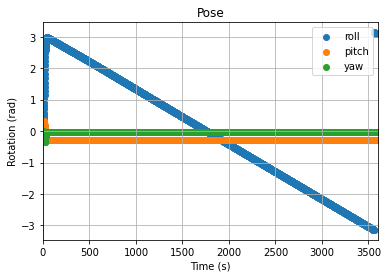

In [19]:
plt.scatter(t, pose[:,0], label='roll')
plt.scatter(t, pose[:,1], label='pitch')
plt.scatter(t, pose[:,2], label='yaw')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Rotation (rad)')
plt.title("Pose")
plt.grid()
plt.xlim(0,3600)

### ---------------------------------------------------------------------------------------------------

In [131]:
 def euler_from_quaternion(e):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in degrees (counterclockwise)
        pitch is rotation around y in degrees (counterclockwise)
        yaw is rotation around z in degrees (counterclockwise)
        """
        x, y, z, w = e
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return math.degrees(roll_x), math.degrees(pitch_y), math.degrees(yaw_z) 

In [132]:
#! /usr/bin/env python3
 
# This program converts Euler angles to a quaternion.
# Author: AutomaticAddison.com
 
import numpy as np # Scientific computing library for Python
 
def get_quaternion_from_euler(roll, pitch, yaw):
  """
  Convert an Euler angle to a quaternion.
   
  Input
    :param roll: The roll (rotation around x-axis) angle in radians.
    :param pitch: The pitch (rotation around y-axis) angle in radians.
    :param yaw: The yaw (rotation around z-axis) angle in radians.
 
  Output
    :return qx, qy, qz, qw: The orientation in quaternion [x,y,z,w] format
  """
  qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
  qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
  qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)
  qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
 
  return [qx, qy, qz, qw]

In [134]:
# XYX, XYZ, XZX, XZY, YXY, YXZ, YZX?, YZY, ZXY, ZXZ, ZYX?, ZYZ

(0.0, 3600.0)

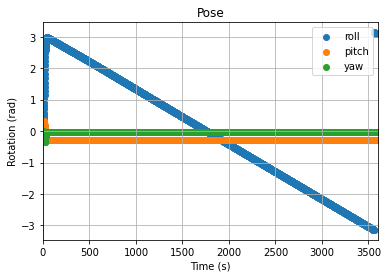

In [30]:
# 3pi in the yaw means we are facing the wrong direction
# slight pitch for some reason
# should rotate in the YAW

# SECOND IDEAL CASE

In [31]:
first = np.array(ideal_mag[:,2])
second = np.array(ideal_mag[:,1])
third = np.array(ideal_mag[:,0])

In [32]:
first_gyr = np.array(ideal_gyr[:,2])
second_gyr = np.array(ideal_gyr[:,1])
third_gyr = np.array(ideal_gyr[:,0])

In [33]:
ideal_mag2 = np.vstack((first, second, third)).T
ideal_gyr2 = np.vstack((first_gyr, second_gyr, third_gyr)).T

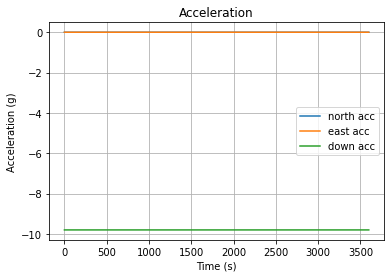

In [34]:
plt.plot(t, ideal_acc[:,0], label='north acc')
plt.plot(t, ideal_acc[:,1], label='east acc')
plt.plot(t, ideal_acc[:,2], label='down acc')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title("Acceleration")
plt.grid()

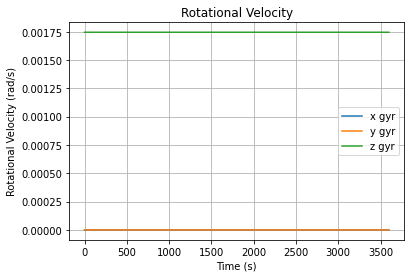

In [35]:
plt.plot(t, ideal_gyr[:,0], label='x gyr')
plt.plot(t, ideal_gyr[:,1], label='y gyr')
plt.plot(t, ideal_gyr[:,2], label='z gyr')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Rotational Velocity (rad/s)')
plt.title("Rotational Velocity")
plt.grid()

In [ ]:
plt.plot(t, first, label='north mag')
plt.plot(t, second, label='east mag')
plt.plot(t, third, label='down mag')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Magnetometer (uT)')
plt.title("Magnetometer")
plt.grid()

In [ ]:
# ekf2 = EKF()
ekf2 = EKF(gyr=ideal_gyr2, acc=ideal_acc, mag=ideal_mag2, frequency = 2)
num_samples = 7200  # Assuming sensors have 1000 samples each
Q = np.zeros((num_samples, 4))  # Allocate array for quaternions
Predicted = np.zeros((num_samples, 4))
Q[0] = acc2q(ideal_acc[0])       # First sample of tri-axial accelerometer
for s in range(1, num_samples):
    Q[s] = ekf2.update(Q[s-1], ideal_gyr[s], ideal_acc[s], ideal_mag2[s]) # calculated Quaternions
#     Predicted[s] = ekf2.f(Q[s-1], ideal_gyr[s])               # predicted next Quaternio

In [ ]:
Q

In [ ]:
pose = np.zeros((num_samples, 3))
for i in range(num_samples):
    pose[i] = R.from_quat(Q[i]).as_euler('XYZ')

In [ ]:
plt.scatter(t, pose[:,0], label='roll')
plt.scatter(t, pose[:,1], label='pitch')
plt.scatter(t, pose[:,2], label='yaw')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Rotation (rad)')
plt.title("Pose")
plt.grid()